# Value at Risk
## Introduction

Value at Risk (VaR) is a widely used financial risk metric that estimates the maximum expected loss of a portfolio over a given time horizon at a specified confidence level, based on the probability distribution of returns. Classical VaR calculations for complex portfolios often rely on Monte Carlo simulations, which can be computationally expensive and slow to converge. Quantum computing can improve this process by using Iterative Quantum Amplitude Estimation (IQAE) to estimate loss probabilities more efficiently. IQAE provides a quadratic speedup over classical Monte Carlo methods by estimating expected values with fewer samples, without requiring deep quantum circuits. This makes it particularly suitable for near-term quantum hardware and enables faster, more accurate VaR calculations for high-dimensional and non-linear financial portfolios.

### Modeling the Value at Risk Problem

As a first step, we have to model the problem mathematically. We will use a simple yet powerful model, which captures the essence of portfolio optimization:

First, we will import the Python libraries required for this implementation. Classiq, of course, and Numpy. 

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from classiq import *
from classiq.applications.iqae.iqae import IQAE

Now, we will define the parameters required for the Value at Risk process, and create the probability distribution function.

In [56]:
# How many qubits we want the quantum circuit to be
num_qubits = 7

# Mu (μ) represents the Average
mu = 0.7

# Sigma (σ) represents the Standard Deviation
sigma = 0.13

# The Alpha (α) parameter represents the probability in which P(X > v) = 1 - α
ALPHA = 0.07

# Find Alpha in a given precision
TOLERANCE = ALPHA / 10


def get_log_normal_probabilities(mu_normal, sigma_normal, num_points):
    log_normal_mean = np.exp(mu + sigma**2 / 2)
    log_normal_variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    log_normal_stddev = np.sqrt(log_normal_variance)

    # cutting the distribution 3 sigmas from the mean
    low = np.maximum(0, log_normal_mean - 3 * log_normal_stddev)
    high = log_normal_mean + 3 * log_normal_stddev
    print(log_normal_mean, log_normal_variance, log_normal_stddev, low, high)
    x = np.linspace(low, high, num_points)
    return x, scipy.stats.lognorm.pdf(x, s=sigma_normal, scale=np.exp(mu_normal))


# %%
grid_points, probs = get_log_normal_probabilities(mu, sigma, 2**num_qubits)

2.030841014265948 0.07029323208790372 0.26512870853210846 1.2354548886696226 2.8262271398622736


In order to have a benchmark to our solution, and since the problem space is not too big, let's calculate the Value at Risk classically, and plot the probability distribution function.

Value at risk at 7%: 1.6613309244219858


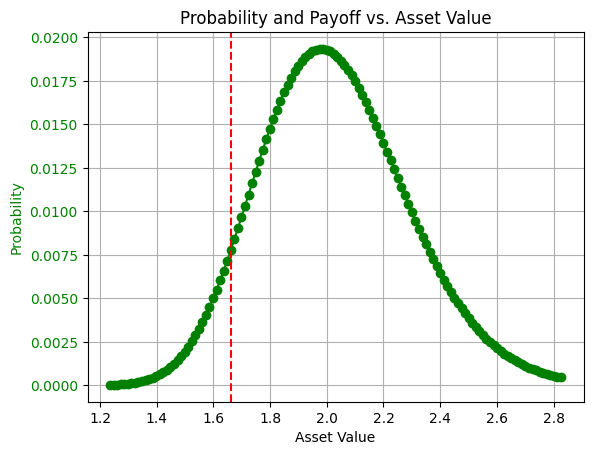

In [57]:
probs = (probs / np.sum(probs)).tolist()

fig, ax1 = plt.subplots()

# Plotting the log-normal probability function
ax1.plot(grid_points, probs, "go-", label="Probability")  # Green line with circles
ax1.tick_params(axis="y", labelcolor="g")
ax1.set_xlabel("Asset Value")
ax1.set_ylabel("Probability", color="g")

# Adding grid and title
ax1.grid(True)
plt.title("Probability and Payoff vs. Asset Value")

VAR = 0
# Find the value at risk ALPHA of grid_points
accumulated_value = 0

for index in range(len(probs)):
    accumulated_value += probs[index]
    if accumulated_value > ALPHA:
        VAR = grid_points[index]
        break

print(f"Value at risk at {int(ALPHA*100)}%: {VAR}")

# Plot the vertical line of VaR at 5%
ax1.axvline(x=VAR, color="r", linestyle="--", label="VaR at 5%")

### The Binary Search Approach To Calculate Value At Risk
We can solve the Value at Risk use-case also with a binary search approach.
This approach will benefit us from a complexity perspective once we will integrate the quantum function that calculates alpha given an index.

In [58]:
# This function calculates the alpha classically given the index and the list of probabilities


def calc_alpha(index: int, probs: list[float]):
    sum_probs = sum([probs[i] for i in range(index)])
    return sum_probs

In [59]:
# This function updates the new index based on the comparison between the measured alpha value and the required value.
# The search size correlates with the current binary search step.


def update_index(index: int, required_alpha: float, alpha_v: float, search_size: int):
    if alpha_v < required_alpha:
        return index + search_size
    return index - search_size

In [60]:
# This is the main Value at Risk function, which gets the required probability (required_alpha), the index and the alpha calculation function
# We aim to use calc_alpha defined above


def print_status(v, alpha_v, search_size, index):
    print(f"v: {v}, alpha_v: {alpha_v}")
    print(f"{search_size=}")
    print(f"{index=}")
    print("------------------------")


def print_results(grid_points, index, probs):
    print(f"Value at risk at {ALPHA*100}%: {grid_points[index]})")
    global VAR
    print(f"Real VaR", VAR)
    return index


def value_at_risk(required_alpha, index, calc_alpha_func=calc_alpha):
    v = probs[index]
    alpha_v = calc_alpha_func(index, probs)
    search_size = index // 2
    print_status(v, alpha_v, search_size, index)

    # Tolerance represents the accuracy of the alpha we aim to get
    while (not np.isclose(alpha_v, required_alpha, atol=TOLERANCE)) and search_size > 0:
        index = update_index(index, required_alpha, alpha_v, search_size)
        # Binary search, divided by 2 - as we know the function is always growing in that part of the graph.
        search_size = search_size // 2
        v = grid_points[index]
        alpha_v = calc_alpha_func(index, probs)
        print_status(v, alpha_v, search_size, index)

    print_results(grid_points, index, probs)

In [61]:
def get_initial_index():
    return int(2**num_qubits) // 4


index = get_initial_index()
var_index = value_at_risk(ALPHA, index)

v: 0.0065948768440761245, alpha_v: 0.05208420102593402
search_size=16
index=32
------------------------
v: 1.8366916450259, alpha_v: 0.23233572478018774
search_size=8
index=48
------------------------
v: 1.7364855189665205, alpha_v: 0.12198155535389908
search_size=4
index=40
------------------------
v: 1.6863824559368308, alpha_v: 0.0820204268594856
search_size=2
index=36
------------------------
v: 1.6613309244219858, alpha_v: 0.06585414330510068
search_size=1
index=34
------------------------
Value at risk at 7.000000000000001%: 1.6613309244219858)
Real VaR 1.6613309244219858


## Value at Risk using Iterative Quantum Amplitude Estimation (IQAE)

Iterative Quantum Amplitude Estimation (IQAE) is a key algorithm in the quantum computing toolbox. It is useful for quantum-enhanced Monte Carlo methods, which are in use for several important quantum finance applications like Value at Risk (VaR) estimation.

The goal of Quantum Amplitude Estimation (QAE) is to estimate the probability (or amplitude) of a certain outcome from a quantum circuit. Compared to other classical methods, some has been presented above in this notebook - it is potentially quadratically faster.

IQAE is a NISQ-friendly version of the traditional Quantum Amplitude Estimation (QAE), and includes the following stages:

- State preparation encoding the desired probabilty, in this case - for not losing more than $X for an asset or a portfolio of asset.
- Use controlled applications of the Grover operator (unlike QAE, which utilises Fourier Transform)
- Measure and update the estimate using classical methods. 


### Defining The State Preparation for the IQAE Algorithm

In order to use IQAE, we need to define the state preparation function, which includes two main parts:
- Loading the distribution of the asset values into a quantum state.
- Defining the payoff function, which marks the states where the asset value is below a certain threshold (the index in this case).

For the first part, we will use Classiq's inpalce_prepare_state function.
For the second part, we will define a simple comparison operation using Classiq's arithmetic library.

In [62]:
@qfunc(synthesize_separately=True)
def state_preparation(asset: QArray[QBit], ind: QBit):
    load_distribution(asset=asset)
    payoff(asset=asset, ind=ind)


@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)


@qperm
def payoff(asset: Const[QNum], ind: QBit):
    ind ^= asset < GLOBAL_INDEX

In [63]:
written_qmod = False


def calc_alpha_quantum(index: int, probs: list[float]):

    # Global variable
    global GLOBAL_INDEX
    GLOBAL_INDEX = index

    # Creation of the model, given the constratins and the circuit preferences
    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits),
    )

    qprog = iqae.get_qprog()

    global written_qmod
    qmod = iqae.get_model()
    if not written_qmod:
        written_qmod = True
        show(qprog)

    iqae_res = iqae.run(epsilon=0.05, alpha=0.01)

    # Result of the iterative QAE
    # iqae_res = res[0].value
    measured_payoff = iqae_res.estimation
    confidence_interval = np.array(
        [interval for interval in iqae_res.confidence_interval]
    )
    print("Measured Payoff:", measured_payoff)
    print("Confidence Interval:", confidence_interval)
    return measured_payoff

In [64]:
index = get_initial_index()

In [65]:
var = value_at_risk(ALPHA, index, calc_alpha_quantum)

Quantum program link: https://platform.classiq.io/circuit/36qFOY37WAMOkTlCO3z2qIYymEp
Measured Payoff: 0.0490523131159807
Confidence Interval: [0.04472615 0.05337848]
v: 0.0065948768440761245, alpha_v: 0.0490523131159807
search_size=16
index=32
------------------------
Measured Payoff: 0.22216796875
Confidence Interval: [0.18264898 0.26168696]
v: 1.8366916450259, alpha_v: 0.22216796875
search_size=8
index=48
------------------------
Measured Payoff: 0.12152326550014109
Confidence Interval: [0.11917274 0.12387379]
v: 1.7364855189665205, alpha_v: 0.12152326550014109
search_size=4
index=40
------------------------
Measured Payoff: 0.08329832447556523
Confidence Interval: [0.07589168 0.09070497]
v: 1.6863824559368308, alpha_v: 0.08329832447556523
search_size=2
index=36
------------------------
Measured Payoff: 0.06836725638142506
Confidence Interval: [0.06171807 0.07501644]
v: 1.6613309244219858, alpha_v: 0.06836725638142506
search_size=1
index=34
------------------------
Value at risk at 